In [29]:
import MDAnalysis as mda
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from MDAnalysis.lib.distances import distance_array
from MDAnalysis import units
from MDAnalysis.analysis import rdf
from openmm.unit import AVOGADRO_CONSTANT_NA, BOLTZMANN_CONSTANT_kB
from openmm.unit import kelvin, bar, litre, kilojoule_per_mole, mole, nanometer, angstrom, kilocalorie_per_mole
from openmm.unit import Quantity, Unit
import quantities
from matplotlib import colors
from matplotlib.ticker import PercentFormatter


## Loading data and creating atom group of ions

In [30]:
u = mda.Universe('md.gro', 'md.xtc')
print(u, '\n', u.atoms, '\n', u.trajectory)

u.transfer_to_memory()

ions= u.select_atoms('resname NA CL')
print(len(u.trajectory))

waters=u.select_atoms('resname SOL')
nas=u.select_atoms('resname NA')
cls=u.select_atoms('resname CL')

box_size = u.dimensions[:3] * angstrom
print(box_size)

<Universe with 33430 atoms> 
 <AtomGroup [<Atom 1: OW of type O of resname SOL, resid 66 and segid SYSTEM>, <Atom 2: HW1 of type H of resname SOL, resid 66 and segid SYSTEM>, <Atom 3: HW2 of type H of resname SOL, resid 66 and segid SYSTEM>, ..., <Atom 33428: OW of type O of resname SOL, resid 11165 and segid SYSTEM>, <Atom 33429: HW1 of type H of resname SOL, resid 11165 and segid SYSTEM>, <Atom 33430: HW2 of type H of resname SOL, resid 11165 and segid SYSTEM>]> 
 <XTCReader md.xtc with 151 frames of 33430 atoms>
151
[ 48.537327  48.537327 144.22682 ] A


In [45]:
zdim=[]
for b in u.trajectory:
    z_box=u.dimensions[2:3]
    zdim.append(z_box)
    zcenter=z_box/2
 #   print(zcenter)

#print(np.average(zdim))

## Function for calculating osmotic values:

In [32]:

R = BOLTZMANN_CONSTANT_kB * AVOGADRO_CONSTANT_NA # gas constant

def osmotic_values(mean_force_wall, molarity :Quantity, vant_hoff : int=2, T=300*kelvin, cross_sectional_area : Quantity=48*48 * angstrom**2 ):
    osm_press=mean_force_wall/cross_sectional_area
    osm_bar = osm_press.in_units_of(bar / mole)
    osm_bar = osm_bar/AVOGADRO_CONSTANT_NA
    print(f"Osmotic Pressure Observed:", osm_bar)
    osm_press_ideal=vant_hoff*molarity*R*T
    osm_press_ideal=osm_press_ideal.in_units_of(bar)
    print(f"Osmotic Pressure Ideal:", osm_press_ideal)
    osm_coeff=osm_bar/osm_press_ideal
    #osm_coeff=(osm_bar/(vant_hoff* molarity * R * T))*101.32 #Osmotic pressure to osmotic coefficient
    print(f"Osmotic Coefficient:", osm_coeff)

    return osm_coeff

def calculate_net_force(z_values : np.ndarray[float], zwall : float, k : float) -> float:
    return k * abs(z_values - zwall).sum()

In [33]:
k_nm = 4184 * kilojoule_per_mole / nanometer**2
k = k_nm.in_units_of(kilojoule_per_mole / angstrom**2)


walls_z_pos = np.array([48, 96]) * angstrom
forces_at_ts = {
    48 : [],
    96 : []
}

for _ in u.trajectory:
    ions_z = ions.positions[:,2]*angstrom
    force_48 = calculate_net_force(
        z_values=ions_z[ions_z < 48*angstrom],
        zwall=48*angstrom,
        k=k
    )
    forces_at_ts[48].append(force_48)

    force_96 = calculate_net_force(
        z_values=ions_z[ions_z > 96*angstrom],
        zwall=96*angstrom,
        k=k
    )
    forces_at_ts[96].append(force_96)

mean_forces = {
    abs_wall_z : sum(force_list, start=0*(kilojoule_per_mole / angstrom)) / len(u.trajectory)
        for abs_wall_z, force_list in forces_at_ts.items()
}

mean_forces

{48: Quantity(value=2.6350639656521633, unit=kilojoule/(angstrom*mole)),
 96: Quantity(value=10.584899296034253, unit=kilojoule/(angstrom*mole))}

In [34]:
ions_at_48=[]
ions_at_96=[]
zpositions=[]

for _ in u.trajectory:
    ions_z = ions.positions[:,2]*angstrom
    zpositions.append(ions_z)
    z_values48=ions_z[ions_z < 48*angstrom]
    z_values96=ions_z[ions_z > 96*angstrom]
    ions_at_48.append(z_values48)
    ions_at_96.append(z_values96)

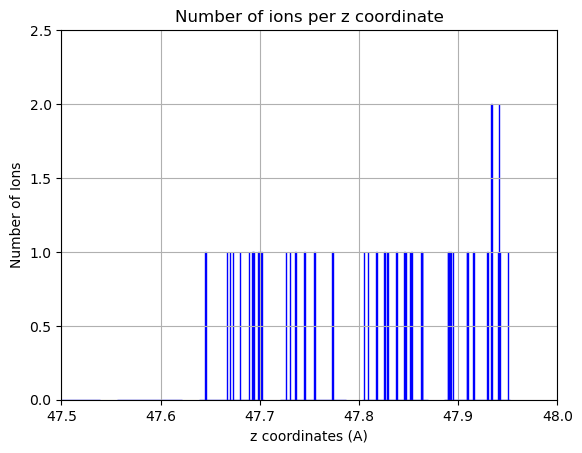

In [46]:
plt.hist(ions_at_48,bins='auto',edgecolor='blue')
plt.xlabel('z coordinates (A)')
plt.ylabel('Number of Ions')
plt.title('Number of ions per z coordinate')
plt.axis([47.5, 48, 0, 2.5])
# Display the plot
plt.grid(True)
plt.show()


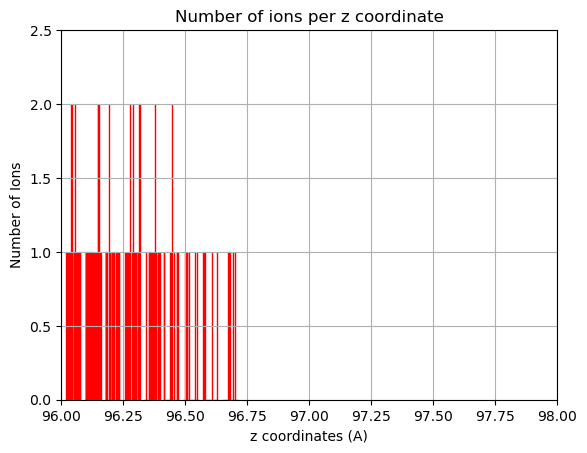

In [47]:
plt.hist(ions_at_96,bins='auto',edgecolor='red')
plt.xlabel('z coordinates (A)')
plt.ylabel('Number of Ions')
plt.title('Number of ions per z coordinate')
plt.axis([96, 98, 0, 2.5])
plt.grid(True)
plt.show()

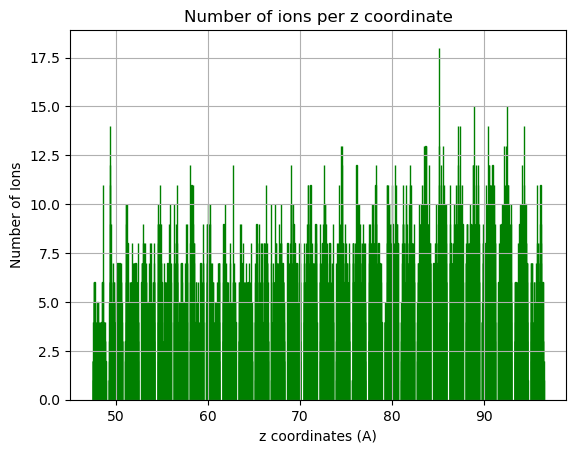

In [37]:
plt.hist(zpositions,bins='auto',edgecolor='green')
plt.xlabel('z coordinates (A)')
plt.ylabel('Number of Ions')
plt.title('Number of ions per z coordinate')

# Display the plot
plt.grid(True)
plt.show()


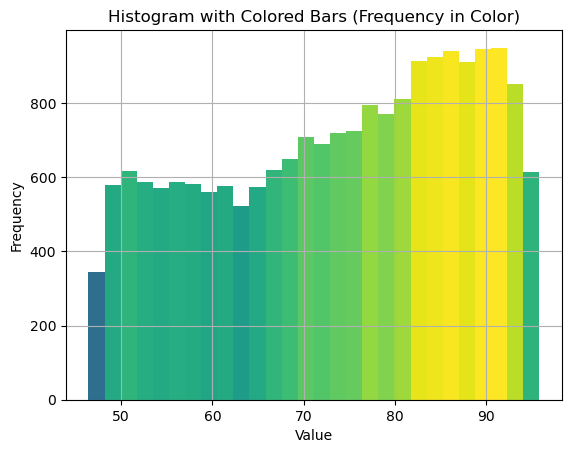

In [38]:
n_bins = 'auto'

# Create histogram
hist, bins = np.histogram(zpositions, bins=n_bins)

# Normalize the histogram frequencies to the range [0, 1]
hist_normalized = hist / hist.max()

# Define colors for each bin based on normalized frequency
colors = plt.cm.viridis(hist_normalized)

# Plot histogram with colored bars
plt.bar(bins[:-1], hist, width=np.diff(bins), color=colors)

# Add labels and title
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.title('Histogram with Colored Bars (Frequency in Color)')

# Display the plot
plt.grid(True)
plt.show()


In [39]:
box_x = box_size[0]
box_y = box_size[1]
A_box = box_x * box_y

dim_mem = walls_z_pos.ptp() * walls_z_pos.unit
V_mem = A_box * dim_mem

n_part = 130
M = n_part / (V_mem * AVOGADRO_CONSTANT_NA)
M = M.in_units_of(mole / litre)
print(M)

for wall_z_val, mF in mean_forces.items():
    print(wall_z_val)
    o = osmotic_values(mF, molarity=M, cross_sectional_area=A_box)

1.9089717831463633 mol/L
48
Osmotic Pressure Observed: 18.573277872796567 bar
Osmotic Pressure Ideal: 95.23244718047862 bar
Osmotic Coefficient: 0.19503098389982193
96
Osmotic Pressure Observed: 74.60778123166226 bar
Osmotic Pressure Ideal: 95.23244718047862 bar
Osmotic Coefficient: 0.7834281638302356


In [40]:
av_mF=(mean_forces[48]+mean_forces[96])/2
o = osmotic_values(av_mF, molarity=M, cross_sectional_area=A_box)

Osmotic Pressure Observed: 46.590529552229405 bar
Osmotic Pressure Ideal: 95.23244718047862 bar
Osmotic Coefficient: 0.4892295738650287


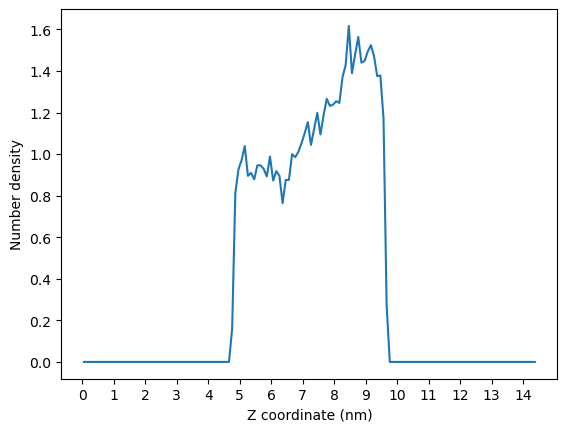

In [41]:
x,y = np.loadtxt("density.xvg",comments=["@", "#"],unpack=True)
plt.plot(x,y)
plt.xlabel("Z coordinate (nm)")
plt.ylabel("Number density")
plt.xticks(np.arange(0, 14.4, 1.0))
#plt.savefig("volume.png", format="png", dpi=300)
plt.show()

In [42]:
list48=forces_at_ts[48]
list96=forces_at_ts[96]
f48=[]
f96=[]
time=[]
for i,ts in enumerate(u.trajectory):
    time.append(u.trajectory.time)
    val48=list48[i]
    val96=list96[i]
    f48.append(val48.item())
    f96.append(val96.item())


print(f48)
print(len(time))

[0.0, 0.0, 0.0, 8.367872314453125, 0.0, 0.0, 0.0, 0.0, 4.602425537109375, 0.0, 1.6736383056640627, 0.0, 9.623021240234376, 9.20485107421875, 2.928787231445313, 0.0, 12.13347869873047, 0.0, 0.0, 0.0, 4.183776550292969, 0.0, 10.46, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 8.367872314453125, 0.0, 10.46, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 29.28803192138672, 0.0, 0.0, 8.367872314453125, 4.183776550292969, 0.0, 3.76544677734375, 10.46, 0.0, 5.857574462890626, 0.0, 7.531212768554688, 0.0, 0.0, 0.0, 0.0, 0.0, 14.643936157226564, 0.0, 4.602425537109375, 0.0, 0.0, 0.0, 0.0, 12.551808471679688, 0.0, 0.0, 0.0, 0.0, 0.0, 10.87832977294922, 22.174989318847658, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 12.970297851562501, 0.0, 6.694234008789063, 0.0, 0.0, 2.5102978515625, 29.706202087402346, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 4.1839361572265625, 5.857574462890626, 0.0, 0.0, 6.694234008789063, 0.0, 0.0, 14.225446777343752, 0.0, 0.0, 0.

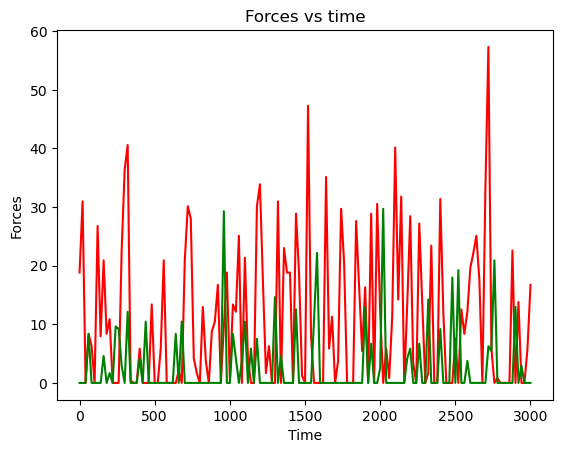

In [43]:
plt.plot(time,f96, color='r', label='9.6 nm')
plt.plot(time,f48, color='g', label='4.8 nm')
plt.ylabel("Forces")
plt.xlabel("Time")
plt.title("Forces vs time")
#plt.xticks(np.arange(0, 14.4, 1.0))
#plt.savefig("volume.png", format="png", dpi=300)
plt.show()

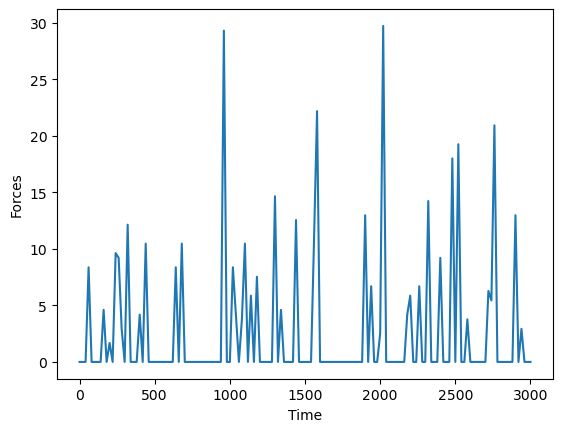

In [44]:
plt.plot(time,f48)
plt.ylabel("Forces")
plt.xlabel("Time")
#plt.xticks(np.arange(0, 14.4, 1.0))
#plt.savefig("volume.png", format="png", dpi=300)
plt.show()